In [87]:
from utility import *

from collections import Counter
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
import seaborn as sns
import collections
import json as json
from scipy import stats

%matplotlib inline

In [92]:
# df display side by side (code from stackoverflow: https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side)

from IPython.display import display, HTML
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [46]:
# read in decagon data
combo2stitch, combo2se, se2name = load_combo_se(fname='../data/decagon_data/bio-decagon-combo.csv')
net, node2idx = load_ppi(fname='../data/decagon_data/bio-decagon-ppi.csv')
stitch2se, se2name_mono = load_mono_se(fname='../data/decagon_data/bio-decagon-mono.csv')
stitch2proteins = load_targets(fname='../data/decagon_data/bio-decagon-targets.csv')
se2class, se2name_class = load_categories(fname='../data/decagon_data/bio-decagon-effectcategories.csv')
se2name.update(se2name_mono)
se2name.update(se2name_class)

Reading: ../data/decagon_data/bio-decagon-combo.csv
Drug combinations: 63473 Side effects: 1317
Drug-drug interactions: 4649441
Reading: ../data/decagon_data/bio-decagon-ppi.csv
Edges: 715612
Nodes: 19081
Reading: ../data/decagon_data/bio-decagon-mono.csv
Reading: ../data/decagon_data/bio-decagon-targets.csv
Reading: ../data/decagon_data/bio-decagon-effectcategories.csv


In [51]:
# read in cvd data
cvd_df = pd.read_csv("../data/cvd_df.csv")

In [52]:
len(cvd_df)

15

In [53]:
# summary of original dataset

# drugs with protein info
drugs_w_protein = list(stitch2proteins.keys())
print("drug proteins: " + str(len(drugs_w_protein)))

# drugs with individual SE info 
drugs_w_indiv_se = list(stitch2se.keys())
print("indiv drugs: " + str(len(drugs_w_indiv_se)))

# drugs with combo SE info
combo_drugs = np.unique(np.array([i for pair in list(combo2stitch.values()) for i in pair]))
print("combo drugs: " + str(len(combo_drugs)))

# total drugs
total_drugs = []
[total_drugs.extend(li) for li in (drugs_w_protein, drugs_w_indiv_se, combo_drugs)]
total_drugs = np.array(total_drugs)
total_drugs = np.unique(np.array(total_drugs))
print("total unique drugs: " + str(len(total_drugs)))

drug proteins: 284
indiv drugs: 639
combo drugs: 645
total unique drugs: 645


# Preliminary EDA

### Top 10 SE Classes

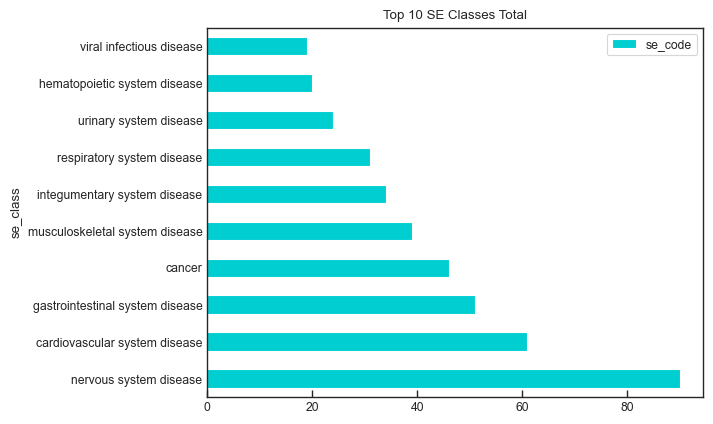

In [54]:
# top 10 types of side effect classes

se_classes = pd.DataFrame({"se_code": list(se2class.keys()),
             "se_class": list(se2class.values())})

se_names = pd.DataFrame({"se_code": list(se2name.keys()),
                        "se_name": list(se2name.values())})

se_classes.groupby("se_class", as_index=False) \
    .agg({"se_code": len}) \
    .sort_values("se_code", ascending=False) \
    .head(10) \
    .plot.barh(x="se_class", title='Top 10 SE Classes Total', color="darkturquoise");

### Top 10 Side Effects for Individual Drugs

In [55]:
# function that returns the top n single side effects of the drugs given

def get_top_se(drug_ids, n = 10, df = stitch2se):
    single_se = []
    for drug_id in drug_ids:
        for i_se in df[drug_id]:
            single_se.append(i_se)
    
    single_se_df = pd.DataFrame({"se": single_se})
    single_se_df = pd.merge(single_se_df, se_names, how = "left", left_on = "se", right_on = "se_code")
    top_ten = single_se_df.groupby("se_name", as_index=False) \
        .agg({"se": len}) \
        .sort_values("se", ascending=False) \
        .head(n)
    
    return top_ten

In [93]:
# top ten SEs for all drugs
top_single_se_all = get_top_se(stitch2se.keys())

# top ten SEs for CVD drugs
top_single_se_cvd = get_top_se(cvd_df.total_drugs)

display_side_by_side([top_single_se_all, top_single_se_cvd], captions=["All Drugs Top Single SEs", "CVD Drugs Top Single SEs"])

,se_name,se
4815,general physical health deterioration,301
5316,hypoaesthesia,279
6335,mental status changes,278
8992,tooth extraction,276
4160,emotional distress,275
1579,alanine aminotransferase increased,273
3360,condition aggravated,270
7562,pollakiuria,267
8671,staphylococcal infection,266
2452,blood creatinine increased,263


In [94]:
# overlap between top 10 SEs
pd.merge(top_single_se_all, top_single_se_cvd, how="inner", on="se_name")

,se_name,se_x,se_y
0,emotional distress,275,9
1,blood creatinine increased,263,12


### Top 10 Side Effects Per Drug Combination

In [95]:
# to help filter top ten SEs for any combination of drugs containing at least one CVD drug and 2 CVD drugs

one_cvd = []
two_cvd = []

for key in list(combo2se.keys()):
    drugs = key.split("_")
    if drugs[0] in list(cvd_df.total_drugs):
        one_cvd.append(key)
        if drugs[1] in list(cvd_df.total_drugs):
            two_cvd.append(key)
    elif drugs[1] in list(cvd_df.total_drugs):
        one_cvd.append(key)

In [96]:
print("total number of drug-drug pairs: " + str(len(combo2se.keys())))
print("total number of drug-drug pairs with at least one cvd drug: " + str(len(one_cvd)))
print("total number of drug-drug pairs with 2 cvd drugs: " + str(len(two_cvd)))

total number of drug-drug pairs: 63473
total number of drug-drug pairs with at least one cvd drug: 5206
total number of drug-drug pairs with 2 cvd drugs: 78


In [97]:
pd.DataFrame({"drug_pairs": one_cvd}).to_csv("../data/one_cvd.csv")
pd.DataFrame({"drug_pairs": two_cvd}).to_csv("../data/two_cvd.csv")

In [98]:
# top ten SEs for any combination of drugs

top_combo_se_all = get_top_se(combo2se.keys(), df = combo2se)

top_combo_se_one = get_top_se(one_cvd, df = combo2se)

top_combo_se_two = get_top_se(two_cvd, df = combo2se)

In [99]:
# display dfs 

display_side_by_side([top_combo_se_all, top_combo_se_one, top_combo_se_two], \
                     captions=["All Drug Pairs Top SEs", ">= 1 CVD Drug Top SEs", "2 CVD Drugs Top SEs"])

,se_name,se
373,arterial pressure NOS decreased,28568
342,anaemia,27006
102,Difficulty breathing,26037
1006,nausea,25190
1015,neumonia,24430
132,Fatigue,24260
210,Pain,23894
603,diarrhea,23848
384,asthenia,23515
652,emesis,23043


In [101]:
# overlap between top 10 all drugs and at least 1 CVD drug
all_one = pd.merge(top_combo_se_all, top_combo_se_one, how="inner", on="se_name")

# overlap between top 10 all drugs and 2 CVD drug
all_two = pd.merge(top_combo_se_all, top_combo_se_two, how="inner", on="se_name")

# overlap between at least 1 CVD drug and 2 cvd drug
one_two = pd.merge(top_combo_se_two, top_combo_se_one, how="inner", on="se_name")

display_side_by_side([all_one, all_two, one_two], \
                     captions=["Overlap: All vs >= 1", "Overlap: All vs 2", "Overlap: >= 1 vs 2"])

,se_name,se_x,se_y
0,arterial pressure NOS decreased,28568,2471
1,anaemia,27006,2461
2,Difficulty breathing,26037,2443
3,nausea,25190,2057
4,neumonia,24430,2114
5,Pain,23894,1999
6,diarrhea,23848,1965
,se_name,se_x,se_y
0,arterial pressure NOS decreased,28568,43
1,anaemia,27006,40


### Cardiovascular Side Effects for all Drugs

In [102]:
# look into cardiovascular side effects for all drugs

pd.merge(se_classes[se_classes["se_class"] == "cardiovascular system disease"], \
         se_names, on = "se_code", how = "inner")

,se_code,se_class,se_name
0,C0032807,cardiovascular system disease,Post thrombotic syndrome
1,C0003486,cardiovascular system disease,aortic aneurysm
2,C0038454,cardiovascular system disease,apoplexy
3,C0027051,cardiovascular system disease,heart attack
4,C0034072,cardiovascular system disease,Cor pulmonale
...,...,...,...
56,C0026267,cardiovascular system disease,mitral valve prolapse
57,C0018818,cardiovascular system disease,ventricular septal defect
58,C0018817,cardiovascular system disease,atrial septal defect
59,C0031039,cardiovascular system disease,pericardial effusion


### Median Number of Side Effects Per Drug Combination

In [111]:
def plot_distribution(dist, ax = 0, title="", x_label="", y_label="", file_name=None):
    sns.set_context("paper", font_scale=2)
    sns.set_style('ticks')
    sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
    sns.histplot(dist, kde=False, color=sns.xkcd_rgb['cornflower'], bins=20, ax = axs[ax])
    # plt.savefig("plots/" + title + '.png')
    axs[ax].set(xlabel=x_label,
               ylabel=y_label,
               title=title);

Median number of side effects per All Drug Pairs: 53.0
Median number of side effects per >= 1 CVD Drug in Pair: 65.0
Median number of side effects per 2 CVD Drug Pair: 124.5


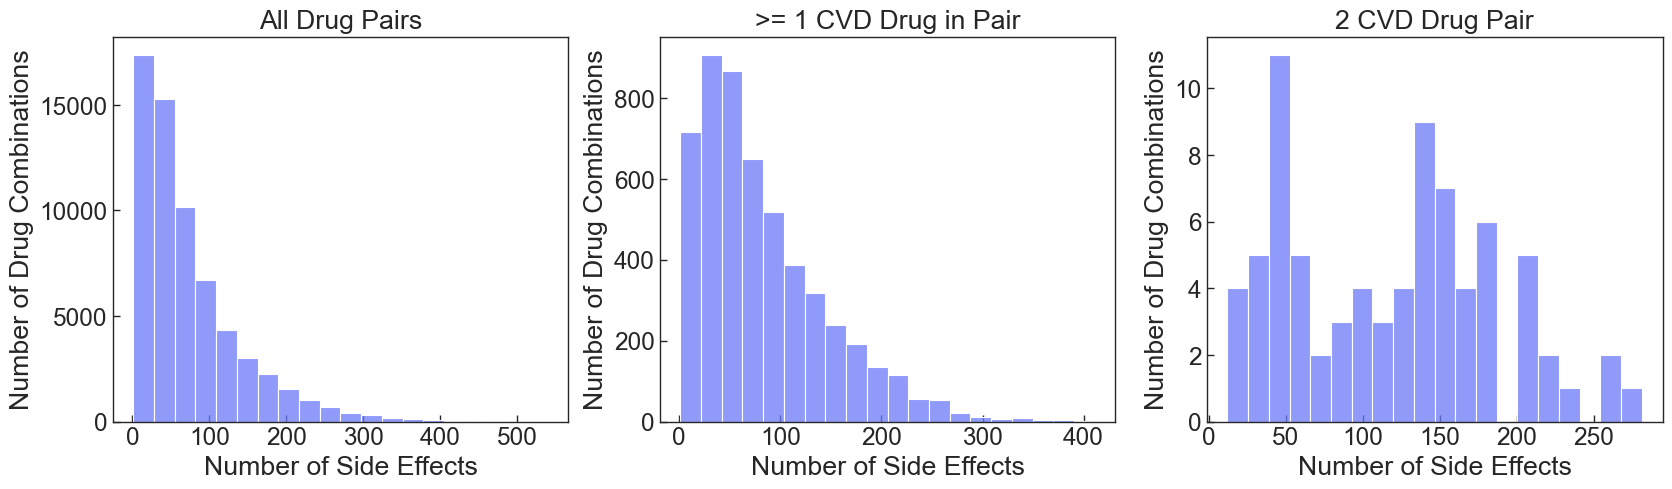

In [112]:
fig, axs = plt.subplots(ncols = 3, figsize=(20, 5))


count = 0
for val_list, title in zip([combo2se, one_cvd, two_cvd], ["All Drug Pairs", ">= 1 CVD Drug in Pair", "2 CVD Drug Pair"]):
    distribution_combos = [len(combo2se[combo]) for combo in val_list]
    med = np.median(distribution_combos)
    print(f'Median number of side effects per {title}: {med}')
    plot_distribution(distribution_combos, count, title, "Number of Side Effects", "Number of Drug Combinations")
    count += 1

# Significance Testing

In [108]:
all_drug_pairs_distributions = [len(combo2se[combo]) for combo in combo2se]
one_cvd_pairs_distributions = [len(combo2se[combo]) for combo in one_cvd]
two_cvd_pairs_distributions = [len(combo2se[combo]) for combo in two_cvd]

In [109]:
# all drug pairs vs one cvd drug pairs
stats.kruskal(all_drug_pairs_distributions, one_cvd_pairs_distributions)

KruskalResult(statistic=223.95896122929207, pvalue=1.238418229763484e-50)

In [110]:
# all drug pairs vs two cvd drug pairs
stats.kruskal(all_drug_pairs_distributions, two_cvd_pairs_distributions)

KruskalResult(statistic=41.862558532357376, pvalue=9.791982399216739e-11)